# Summary

This notebook compares the performance of the convex combination with other models.

It uses the Sine low speed high severity dataset.

# Libraries

In [32]:
import sys

# Append root directory of project, the folder which contains src
sys.path.append("../")

from src.convex_combination import ConvexCombination
from src.ddd import DDD
from src.online_bagging import OnlineBagging
from src.drift_detector import DriftDetectorWrapper

# Preparation

## Dataset

In [33]:
# Sine low speed high severity
from river.datasets import synth

class_list = [0, 1]
n_samples = 10000

stream1 = synth.Sine(classification_function=2, balance_classes=True, has_noise=True)
stream2 = synth.Sine(classification_function=3, balance_classes=True, has_noise=True)
drift_stream = synth.ConceptDriftStream(stream1, stream2, position=4000, width=1500)

dataset = drift_stream.take(n_samples)

## Models

In [34]:
# We create a function as a constructor for the logistic regression model
from river import preprocessing, optim, linear_model


def get_logis_reg():
    return preprocessing.StandardScaler() | linear_model.LogisticRegression(
        optimizer=optim.SGD(0.1)
    )

In [35]:
from river import tree, drift

p_ht = {"delta": 1e-07, "max_depth": 25}
p_drift_detector_ddd = {"alpha": 0.95, "beta": 0.90}
p_drift_detector_convex = {"alpha": 0.90, "beta": 0.85}
p_convex = {"gamma": 0.9, "mu": 1, "lambda_error": 0.95, "store_metrics": True}

p_slow_ensemble = {
    "base_classifier_class": tree.HoeffdingTreeClassifier,
    "n_classifiers": 10,
    "lambda_diversity": 1,
    "p_classifiers": p_ht,
    "class_list": class_list,
}
p_fast_ensemble = {
    "base_classifier_class": get_logis_reg,
    "n_classifiers": 10,
    "lambda_diversity": 1,
    "p_classifiers": {},
    "class_list": class_list,
}
slow_learner = DriftDetectorWrapper(
    OnlineBagging(**p_slow_ensemble),
    drift.binary.EDDM(**p_drift_detector_convex),
    train_in_background=False,
)
fast_learner = OnlineBagging(**p_fast_ensemble)
convex_model = ConvexCombination(fast_learner, slow_learner, p_convex=p_convex, class_list=class_list)

# DDD model
p_low_ensemble = {
    "base_classifier_class": tree.HoeffdingTreeClassifier,
    "n_classifiers": 10,
    "lambda_diversity": 1,
    "p_classifiers": p_ht,
    "class_list": class_list,
}
p_high_ensemble = {
    "base_classifier_class": tree.HoeffdingTreeClassifier,
    "n_classifiers": 10,
    "lambda_diversity": 0.1,
    "p_classifiers": p_ht,
    "class_list": class_list,
}
ddd_model = DDD(
    drift_detector=drift.binary.EDDM(**p_drift_detector_ddd),
    p_low_ensemble=p_low_ensemble,
    p_high_ensemble=p_high_ensemble,
    W=1,
    class_list=class_list,
)

# EDDM
eddm_model = DriftDetectorWrapper(
    OnlineBagging(**p_low_ensemble),
    drift.binary.EDDM(**p_drift_detector_convex),
    train_in_background=True,
)

# Base models
ht_model = tree.HoeffdingTreeClassifier(**p_ht)
lg_model = preprocessing.StandardScaler() | linear_model.LogisticRegression(optimizer=optim.SGD(0.1))

model_list = [convex_model, ddd_model, eddm_model, ht_model, lg_model]
n_models = len(model_list)

# Execution

## Main loop

In [36]:
# Lists for storing predictions convex
y_true_list = []
y_pred_list = []

for i in range(n_models):
    y_pred_list.append([])

In [37]:
# Generic loop for convex storing predictions
for idx, (x, y) in enumerate(dataset):
    y_true_list.append(y)
    for i in range(n_models):
        # Predict and update the model
        y_pred = model_list[i].predict_one(x)
        model_list[i].learn_one(x, y)
        y_pred_list[i].append(y_pred)

## Metrics

In [38]:
# Metrics
from river import metrics, utils


metrics_list = []
metrics_cum_list = []

for i in range(n_models):
    model_metrics = [utils.Rolling(metrics.Accuracy(), 250), utils.Rolling(metrics.Accuracy(), 1000)]
    n_metrics = len(model_metrics)

    metrics_list.append(model_metrics)
    metrics_cum_list.append([[] for _ in range(n_metrics)])

In [39]:
# Convert predictions to metrics
for i in range(n_models):
    for idx in range(len(y_true_list)):
        y = y_true_list[idx]
        y_pred = y_pred_list[i][idx]
        # Update the metrics
        for j in range(n_metrics):
            try:
                metrics_list[i][j].update(y, y_pred)
            except:
                metrics_list[i][j].update(y, class_list[0])
                print("ERROR")
            metrics_cum_list[i][j].append(metrics_list[i][j].get())

# Plotting

In [ ]:
# Single plot
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_cum_list[4][metric_n], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_cum_list[3][metric_n], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_cum_list[2][metric_n], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_cum_list[1][metric_n], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_cum_list[0][metric_n], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

## Past plots

Executed 2023-09-02 14:01:06.358514


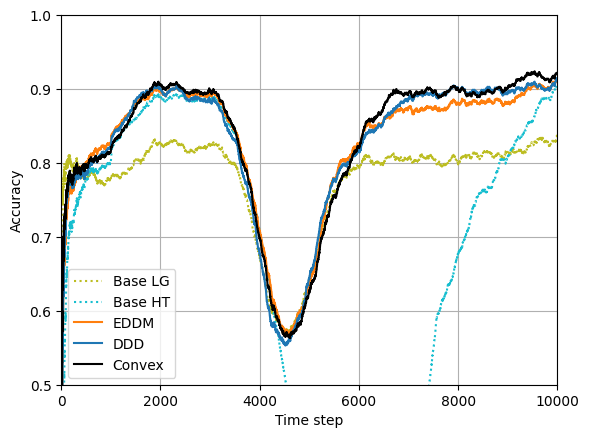

In [40]:
# Plot with final configuration
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_cum_list[4][metric_n], ":", color="tab:olive", label=f"Base LG")
ax.plot(range(1, n_samples + 1), metrics_cum_list[3][metric_n], ":", color="tab:cyan", label=f"Base HT")
ax.plot(range(1, n_samples + 1), metrics_cum_list[2][metric_n], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_cum_list[1][metric_n], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_cum_list[0][metric_n], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

Executed 2023-09-02 13:51:37.337673


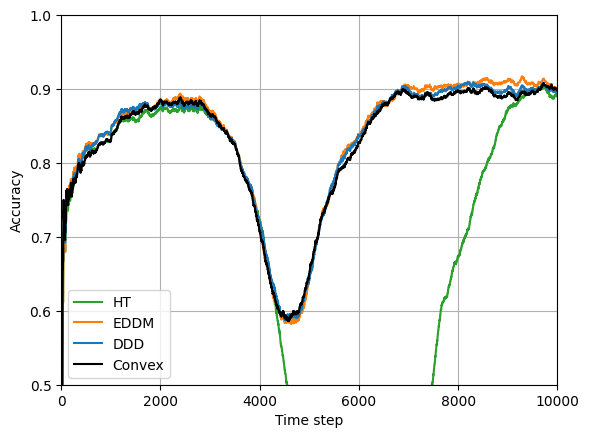

In [12]:
# With midpoint at 4k and width 1.5k
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_cum_list[3][metric_n], "-", color="tab:green", label=f"HT")
ax.plot(range(1, n_samples + 1), metrics_cum_list[2][metric_n], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_cum_list[1][metric_n], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_cum_list[0][metric_n], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend(loc="lower left")
ax.grid()
print(f"Executed {datetime.now()}")

Executed 2023-08-30 19:37:48.499411


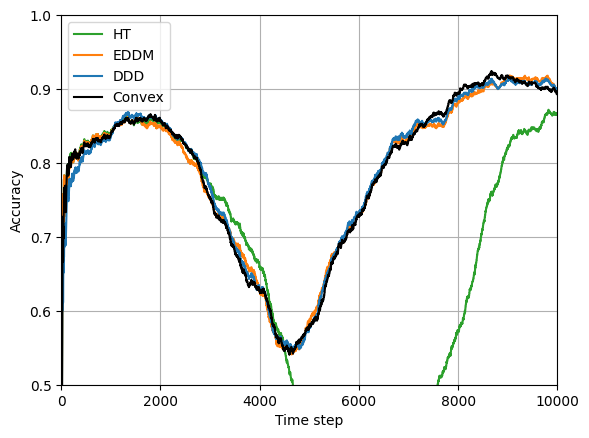

In [44]:
# With midpoint at 4k and width 3k
from datetime import datetime
import matplotlib.pyplot as plt

metric_n = 1

fig, ax = plt.subplots()
ax.plot(range(1, n_samples + 1), metrics_cum_list[3][metric_n], "-", color="tab:green", label=f"HT")
ax.plot(range(1, n_samples + 1), metrics_cum_list[2][metric_n], "-", color="tab:orange", label=f"EDDM")
ax.plot(range(1, n_samples + 1), metrics_cum_list[1][metric_n], "-", color="tab:blue", label=f"DDD")
ax.plot(range(1, n_samples + 1), metrics_cum_list[0][metric_n], "-", color="k", label=f"Convex")
ax.set_xlim(0, n_samples)
ax.set_ylim(0.5, 1)
ax.set_xlabel("Time step")
ax.set_ylabel("Accuracy")
# ax.set_title("Graph title")
ax.legend()
ax.grid()
print(f"Executed {datetime.now()}")